In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models.reg_perceptron import treinar_perceptron_reg, prever_perceptron_reg

2025-07-19 09:36:05.531 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [3]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


Dimensões dos dados de entrada: (400, 2)
Dimensões dos alvos: (400, 1)
------------------------------
Erro Quadrático Médio (EQM): 67.1172 ± 38.9792
Raiz do Erro Quadrático Médio (REQM): 7.9247 ± 2.0777
Hit rate 20%: 0.7667 ± 0.0564
Hit rate 10%: 0.4480 ± 0.0729

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8052 ± 0.0114
Correlação Média (Teste): 0.8023 ± 0.0957
Coeficiente de Determinação (R²): 0.6348 ± 0.1483

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8455, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8442, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


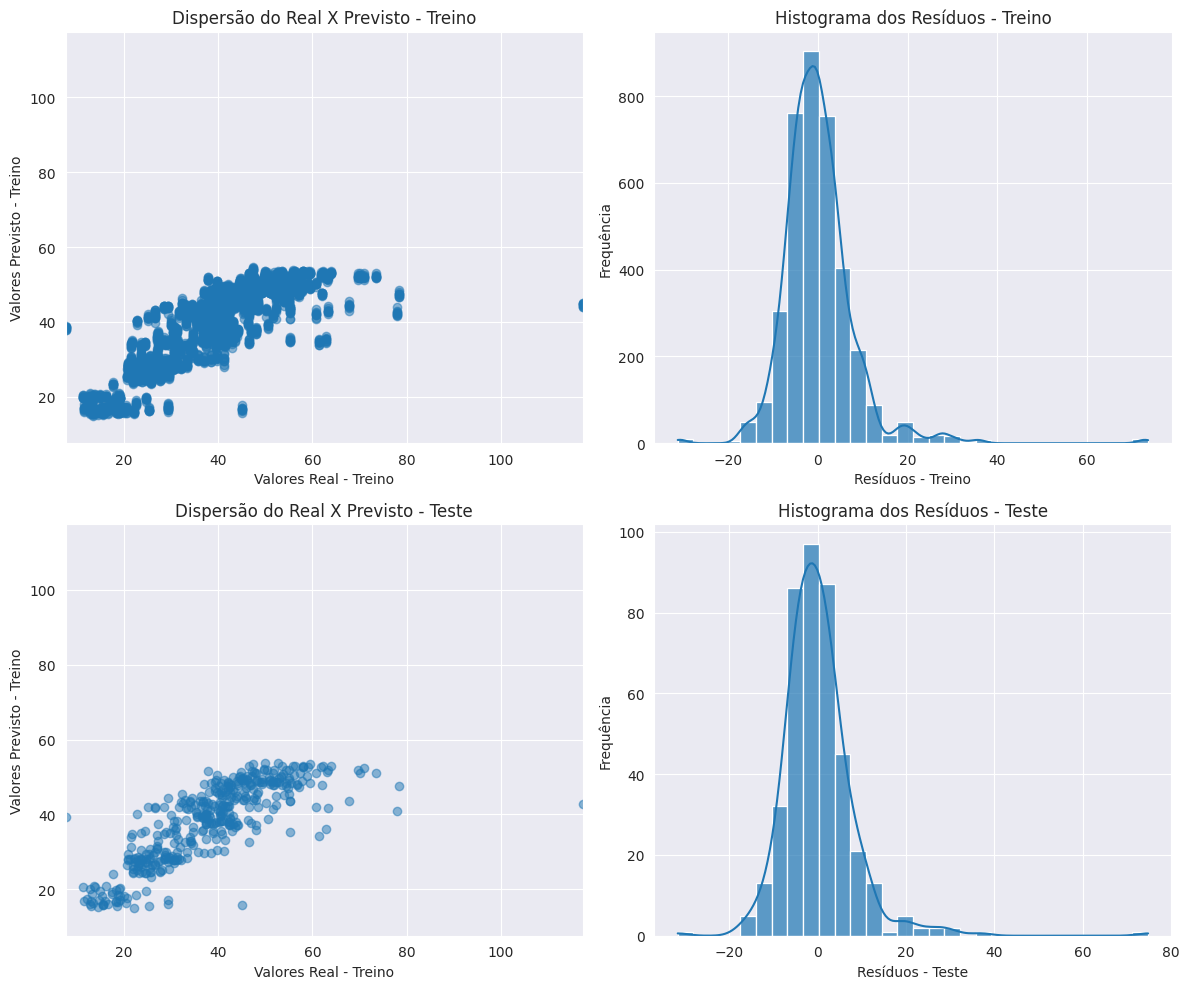

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def inicializar_pesos(n_features, n_outputs, n_hidden):
    """
    Inicializa as matrizes de peso para a MLP.
    """
    W = np.random.rand(n_hidden, n_features + 1) - 0.5
    M = np.random.rand(n_outputs, n_hidden + 1) - 0.5
    return W, M

def treinar_mlp_regressao(X_train, y_train, n_hidden, epochs, eta_i, eta_f, versbose=False):
    """
    Treina a MLP para um problema de REGRESSÃO.
    """
    n_samples, n_features = X_train.shape
    # Para regressão, a saída é geralmente uma única coluna
    n_outputs = y_train.shape[1] if y_train.ndim > 1 else 1

    W, M = inicializar_pesos(n_features, n_outputs, n_hidden)

    mse_history = []
    total_iterations = epochs * n_samples

    for epoch in range(epochs):
        permutation = np.random.permutation(n_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_squared_error = 0.0

        for i in range(n_samples):
            x_sample = X_train_shuffled[i]
            y_target = y_train_shuffled[i]

            # --- Forward Pass ---
            X_b = np.insert(x_sample, 0, -1)
            Ui = W @ X_b
            Yi = np.tanh(Ui) # Não-linearidade na camada oculta
            Y_b = np.insert(Yi, 0, -1)
            Uk = M @ Y_b
            Ok = Uk # MUDANÇA 1: Ativação LINEAR na camada de saída

            # --- Cálculo do Erro ---
            Ek = y_target - Ok
            epoch_squared_error += 0.5 * np.sum(Ek**2)

            # --- Backward Pass ---
            # MUDANÇA 2: A derivada da função linear é 1
            DDk = Ek # O gradiente local da saída é o próprio erro

            Di = 0.5 * (1 - Yi**2)
            DDi = Di * (M[:, 1:].T @ DDk)

            # --- Atualização dos Pesos ---
            current_iteration = epoch * n_samples + i
            eta = eta_i - ((eta_i - eta_f) / total_iterations) * current_iteration

            DDk_col = DDk.reshape(-1, 1)
            Y_b_row = Y_b.reshape(1, -1)
            DDi_col = DDi.reshape(-1, 1)
            X_b_row = X_b.reshape(1, -1)

            M += eta * (DDk_col @ Y_b_row)
            W += eta * (DDi_col @ X_b_row)

        mse_history.append(epoch_squared_error / n_samples)
        if versbose: print(f"Época: {epoch + 1}/{epochs}, MSE: {mse_history[-1]:.6f}")

    return W, M, mse_history

def prever_mlp_regressao(X_test, W, M):
    """
    Realiza a predição de regressão usando pesos já treinados.
    """
    n_samples = X_test.shape[0]
    predictions = []

    for i in range(n_samples):
        x_sample = X_test[i]

        # Forward Pass
        X_b = np.insert(x_sample, 0, -1)
        Ui = W @ X_b
        Yi = np.tanh(Ui)
        Y_b = np.insert(Yi, 0, -1)
        Uk = M @ Y_b
        Ok = Uk # Saída linear
        predictions.append(Ok)

    return np.array(predictions).flatten()

# PARÂMETROS
N_HIDDEN_NEURONS = 20
LEARNING_RATE = 0.0001 # Taxas de aprendizado menores são comuns em regressão
EPOCHS = 50

# CARREGAMENTO DOS DADOS (Exemplo: Dataset de Imóveis)
# try:
#     # Tenta carregar o dataset de imóveis do trabalho TC1
#     # O arquivo Excel original foi convertido para CSV para facilitar.
#     df = pd.read_csv('real_estate.csv')
#     # Removendo colunas não-preditivas
#     df = df.drop(columns=['No', 'X1 transaction date'])
#
#     dados = df.iloc[:, :-1].values
#     alvos = df.iloc[:, -1].values
#
# except FileNotFoundError:
#     print("Arquivo 'real_estate.csv' não encontrado. Gerando dados sintéticos para demonstração.")
#     # Gerando uma função não-linear simples: y = sin(x1) + x2^2 + ruído
#     n_pontos = 400
#     dados = np.random.rand(n_pontos, 2) * 5
#     alvos = np.sin(dados[:, 0]) + dados[:, 1]**0.5 + np.random.randn(n_pontos) * 0.1

# # O usuário pediu para não se preocupar com normalização e divisão treino/teste.
# X_treino = dados
# # Garante que 'alvos' seja um vetor coluna
# y_treino = alvos.reshape(-1, 1)

print(f"Dimensões dos dados de entrada: {X_treino.shape}")
print(f"Dimensões dos alvos: {y_treino.shape}")
print("-" * 30)

# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# MSEs
historicos_mses = []

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

        # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # TREINAMENTO DO MODELO
    W_treinado, M_treinado, historico_mse = treinar_mlp_regressao(
        X_train_k, y_train_k,
        n_hidden=N_HIDDEN_NEURONS,
        epochs=EPOCHS,
        eta_i=LEARNING_RATE,
        eta_f=LEARNING_RATE
    )

    historicos_mses.append(historico_mse)

    # PREDIÇÃO E AVALIAÇÃO (MUDANÇA 3: Novas Métricas)
    y_pred_train = prever_mlp_regressao(X_train_k, W_treinado, M_treinado)
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)


    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)

    # Previsão teste
    y_pred_test = prever_mlp_regressao(X_test_k, W_treinado, M_treinado)
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)


    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão MLP (MLP Regression 1H)'
)


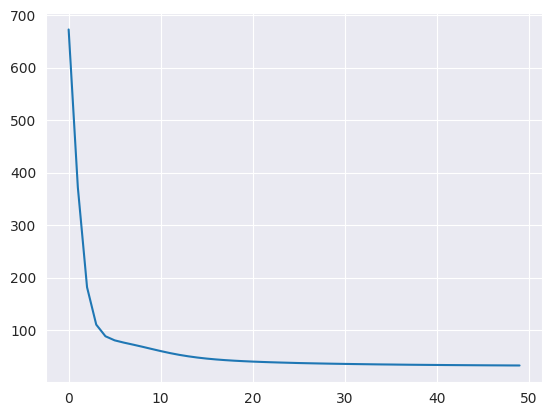

In [29]:
plt.plot(np.mean(historicos_mses, axis=0))